In [3]:
# Imports
import spectral
import numpy as np
from pathlib import Path
import importlib 
import massimal.image_render
import massimal.hyspec_io
# %matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks_cwt, medfilt
import math

import massimal.pipeline

In [4]:
importlib.reload(massimal.pipeline)

<module 'massimal.pipeline' from 'C:\\Users\\mha114\\Dropbox\\Python\\massimal\\src\\massimal\\pipeline.py'>

In [5]:
# Paths
calibration_dir = Path('C:\\Users\\mha114\\Dropbox\\UiT\\Massimal\\Eksempel-datasett\\HSI\\20230830_Olberg\\calibration')
radiance_cailbration_file = calibration_dir / 'RadiometricCal100121-278_081220.icp'
downwelling_calibration_file = calibration_dir / 'FLMS16638_Radiometric_Jan2021.dcp'
raw_image_dir = Path('C:\\Users\\mha114\\Dropbox\\UiT\\Massimal\\Eksempel-datasett\\HSI\\20230830_Olberg\\0_raw')
raw_image_file = raw_image_dir / 'OlbergholmenS1-5/OlbergholmenS1_Pika_L_5.bil.hdr'
raw_image_dw_spec_file = raw_image_dir / 'OlbergholmenS1-5/OlbergholmenS1_downwelling_5_pre.spec.hdr'
# radiance_dir = raw_image_dir.parent / '1_radiance'
# reflectance_dir = raw_image_dir.parent / '2_reflectance'
# radiance_image_file = radiance_dir / raw_image_file.name

In [6]:
rflc = massimal.pipeline.IrradianceConverter(downwelling_calibration_file)

INFO: Non-empty downwelling calibration directory C:\Users\mha114\Dropbox\UiT\Massimal\Eksempel-datasett\HSI\20230830_Olberg\calibration\downwelling_calibration_spectra
INFO: Skipping unzipping of downwelling calibration file, assuming unzipping already done.


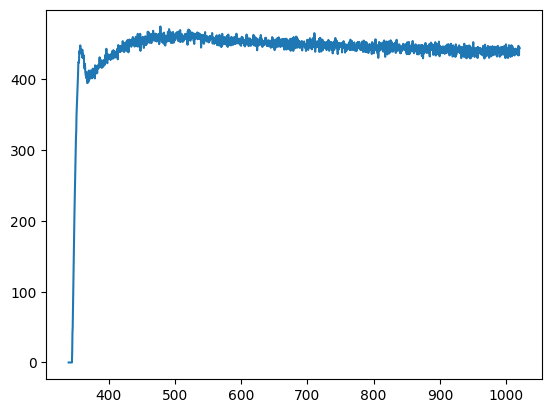

In [7]:
# Plot dark current spectrum
plt.plot(rflc._dw_wl, rflc._dw_dark_spec);

(-1.0, 20.0)

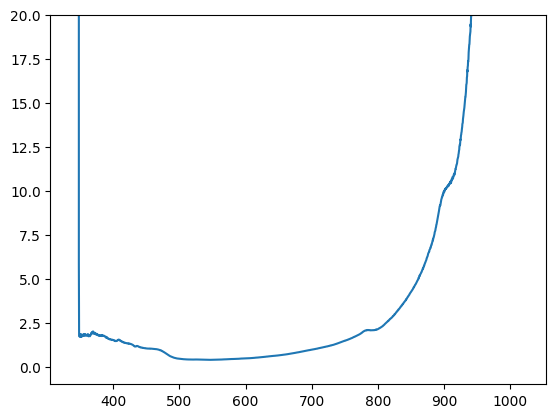

In [8]:
# Plot radiance conversion spectrum
plt.plot(rflc._dw_wl, rflc._dw_conv_spec);
plt.ylim((-1,20))

In [9]:
# Read example downwelling spectrum (from the field)
dw_spec,dw_wl,dw_meta = massimal.pipeline.read_envi(raw_image_dw_spec_file)
dw_spec = np.squeeze(dw_spec)

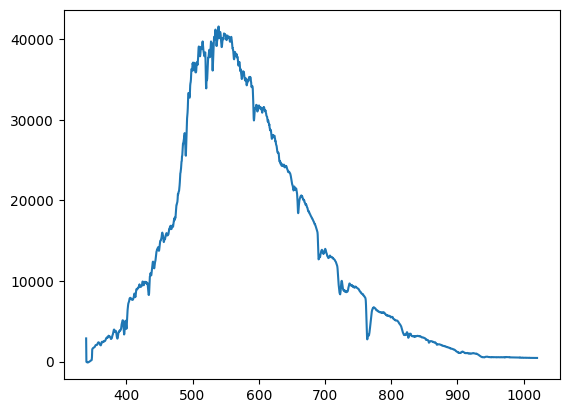

In [10]:
# Plot uncalibrated downwelling spectrum
plt.plot(dw_wl,dw_spec);

In [15]:
# Calibrate downwelling spectrum
dw_spec_cal, dw_wl_cal = rflc.calibrate_downwelling_spectrum(dw_spec,dw_meta)

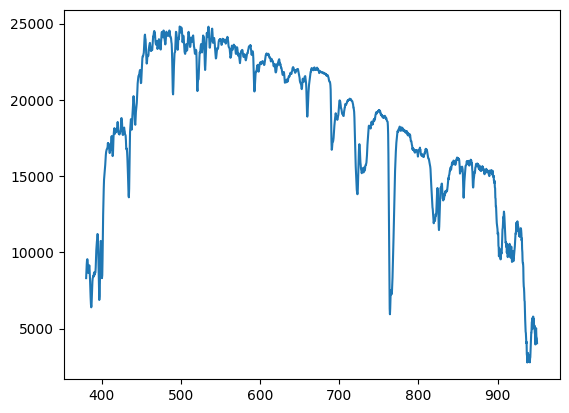

In [18]:
# Plot calibrates downwelling spectrum
plt.plot(dw_wl_cal,dw_spec_cal)

Interesting to compare with "Fraunhofer lines": \
![Fraunhofer lines](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Solar_spectral_irradiance.svg/1024px-Solar_spectral_irradiance.svg.png)

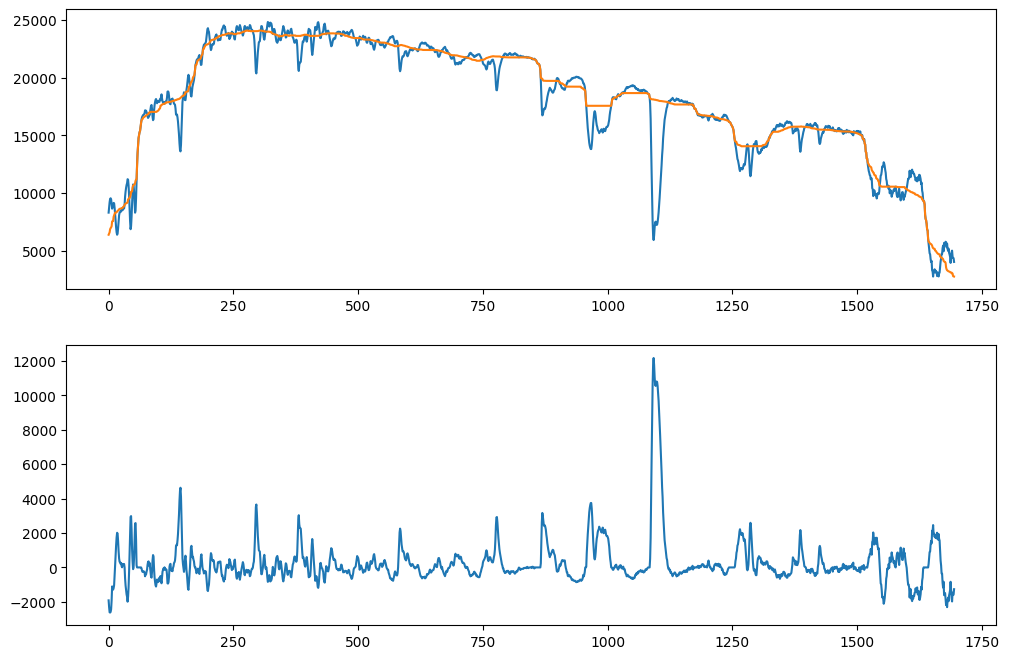

In [21]:
dw_spec_medfilt = medfilt(dw_spec_cal,kernel_size=101)
peak_spec = -(dw_spec_cal-dw_spec_medfilt)
fig,ax = plt.subplots(nrows=2,figsize=(12,8))
ax[0].plot(dw_spec_cal)
ax[0].plot(dw_spec_medfilt)
ax[1].plot(peak_spec)


In [23]:
max_irradiance = np.max(dw_spec_cal)
peaks, peak_properties, = find_peaks(-dw_spec_cal,distance=20,width=5,prominence=max_irradiance*0.1)
print(dw_wl_cal[peaks])
print(f'{len(peaks)} peaks found')

[386.485 396.66  434.038 489.923 520.683 592.705 659.624 690.365 723.004
 763.93  825.871 857.044 903.739 918.138 937.444]
15 peaks found


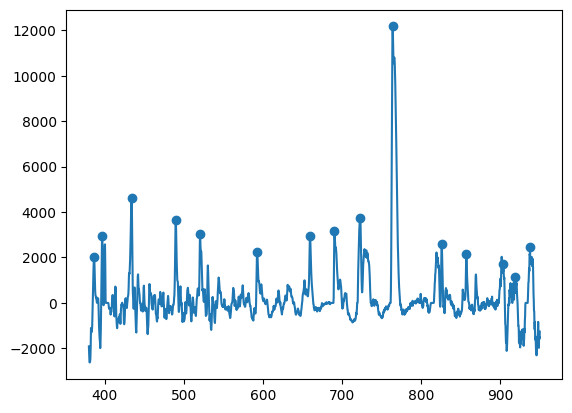

In [26]:
plt.plot(dw_wl_cal,peak_spec)
plt.scatter(dw_wl_cal[peaks],peak_spec[peaks])

In [34]:
def closest_wl_index(wl_array,target_wl):
    """ Get index in sampled wavelength array closest to target wavelength """
    return np.argmin(abs(wl_array-target_wl)) 

In [32]:
ind_380 = closest_wl_index(dw_wl_cal,460)
print(f'Index {ind_380}: {dw_wl_cal[ind_380]} nm')

Index 214: 459.914 nm


In [ ]:
def get_absorption_peak_spectrum(spec,
                                 medfilt_kernel_size=101):
    """ Create absorption peak spectrum based from absorption dip spectrum """
    background_spec = medfilt(spec,kernel_size=medfilt_kernel_size)
    return -(dw_spec_cal-background_spec)

In [ ]:
def detect_spectrum_lines(spec,distance=20,width=5,
                          rel_prominence=0.1):
    """ Detect absorption lines using local peak detection """
    prominence = np.max(spec)*rel_prominence
    peak_spec = get_absorption_peak_spectrum(spec)
    peak_inds, _ = find_peaks(peak_spec, distance=distance,width=width,
                              prominence=prominence)

In [ ]:
def fraunhofer_calibrate_wl(orig_wl,wl_win_width=20):
    # Define wavelengths for Fraunhofer lines
    fraunhofer_wls = {'A':759.37,'B':686.72,'C':656.28,'D':589.30,
                      'b1':518.36,'F':486.13,'G':430.78}
    
    # Define search window for each peak
    fh_wl_ind = [closest_wl_index(orig_wl,fr_wl) for fr_wl in fraunhofer_wls]
    wl_win_half_width_ind = [round((0.5*wl_win_width)/(orig_wl[ind+1]-orig_wl[ind])) 
                             for ind in fh_wl_ind]
    n_wl = len(orig_wl)
    wl_win = [(max(ind-width,0),min(ind+width,n_wl-1))  
              for ind,width in zip(fh_wl_ind, wl_win_half_width_ind)]
    
    

    # Search within each window
    for ind_min, ind_max in wl_win:

    

- 430.78 nm (G)
- 486.13 nm (F)
- 518.36 nm (b1)
- 588.99 nm (D1) + 589.59 (D2) = approx 589.30 nm 
- 656.28 nm (C)
- 686.72 nm (B)
- 759.37 nm (A)